**Chapter 17 – Autoencoders, GANs, and Diffusion Models**

_This notebook contains all the sample code and solutions to the exercises in chapter 17._

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/ageron/handson-ml3/blob/main/17_autoencoders_gans_and_diffusion_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
  <td>
    <a target="_blank" href="https://kaggle.com/kernels/welcome?src=https://github.com/ageron/handson-ml3/blob/main/17_autoencoders_gans_and_diffusion_models.ipynb"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" /></a>
  </td>
</table>

# Setup

This project requires Python 3.7 or above:

In [1]:
import sys

assert sys.version_info >= (3, 7)

It also requires Scikit-Learn ≥ 1.0.1:

In [2]:
from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

And TensorFlow ≥ 2.8:

In [3]:
import tensorflow as tf

assert version.parse(tf.__version__) >= version.parse("2.8.0")

As we did in earlier chapters, let's define the default font sizes to make the figures prettier:

In [4]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

And let's create the `images/generative` folder (if it doesn't already exist), and define the `save_fig()` function which is used through this notebook to save the figures in high-res for the book:

In [5]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "generative"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

This chapter can be very slow without a GPU, so let's make sure there's one, or else issue a warning:

In [6]:
if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. Neural nets can be very slow without a GPU.")
    if "google.colab" in sys.modules:
        print("Go to Runtime > Change runtime and select a GPU hardware "
              "accelerator.")
    if "kaggle_secrets" in sys.modules:
        print("Go to Settings > Accelerator and select GPU.")

# Performing PCA with an Undercomplete Linear Autoencoder

Let's build the Autoencoder...

In [7]:
import tensorflow as tf

tf.random.set_seed(42)  # extra code – ensures reproducibility on CPU

encoder = tf.keras.Sequential([tf.keras.layers.Dense(2)])
decoder = tf.keras.Sequential([tf.keras.layers.Dense(3)])
autoencoder = tf.keras.Sequential([encoder, decoder])

optimizer = tf.keras.optimizers.SGD(learning_rate=0.5)
autoencoder.compile(loss="mse", optimizer=optimizer)

Now let's generate the same 3D dataset as we used in Chapter 8:

In [8]:
# extra code – builds the same 3D dataset as in Chapter 8

import numpy as np
from scipy.spatial.transform import Rotation

m = 60
X = np.zeros((m, 3))  # initialize 3D dataset
np.random.seed(42)
angles = (np.random.rand(m) ** 3 + 0.5) * 2 * np.pi  # uneven distribution
X[:, 0], X[:, 1] = np.cos(angles), np.sin(angles) * 0.5  # oval
X += 0.28 * np.random.randn(m, 3)  # add more noise
X = Rotation.from_rotvec([np.pi / 29, -np.pi / 20, np.pi / 4]).apply(X)
X_train = X + [0.2, 0, 0.2]  # shift a bit

In [9]:
history = autoencoder.fit(X_train, X_train, epochs=500, verbose=False)
codings = encoder.predict(X_train)

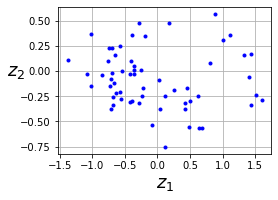

In [10]:
fig = plt.figure(figsize=(4,3))
plt.plot(codings[:,0], codings[:, 1], "b.")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)
save_fig("linear_autoencoder_pca_plot")
plt.show()

# Stacked Autoencoders

## Implementing a Stacked Autoencoder Using Keras

Let's load the fashion MNIST dataset, scale it, and split it into a training set, a validation set, and a test set:

In [11]:
# extra code – loads, scales, and splits the fashion MNIST dataset
fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

Let's build and train a stacked Autoencoder with 3 hidden layers and 1 output layer (i.e., 2 stacked Autoencoders).

In [12]:
tf.random.set_seed(42)  # extra code – ensures reproducibility on CPU

stacked_encoder = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(30, activation="relu"),
])
stacked_decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(28 * 28),
    tf.keras.layers.Reshape([28, 28])
])
stacked_ae = tf.keras.Sequential([stacked_encoder, stacked_decoder])

stacked_ae.compile(loss="mse", optimizer="nadam")                   
history = stacked_ae.fit(X_train, X_train, epochs=20,
                         validation_data=(X_valid, X_valid))

Epoch 1/20
1719/1719 [==============================] - 5s 2ms/step - loss: 0.0241 - val_loss: 0.0194
Epoch 2/20
1719/1719 [==============================] - 4s 3ms/step - loss: 0.0174 - val_loss: 0.0165
Epoch 3/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0161 - val_loss: 0.0160
Epoch 4/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0153 - val_loss: 0.0152
Epoch 5/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0148 - val_loss: 0.0147
Epoch 6/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0144 - val_loss: 0.0144
Epoch 7/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0142 - val_loss: 0.0143
Epoch 8/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0139 - val_loss: 0.0143
Epoch 9/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0137 - val_loss: 0.0140
Epoch 10/20
1719/1719 [==============================] - 6s 3ms/step - loss: 0.013

## Visualizing the Reconstructions

This function processes a few validation images through the autoencoder and displays the original images and their reconstructions:

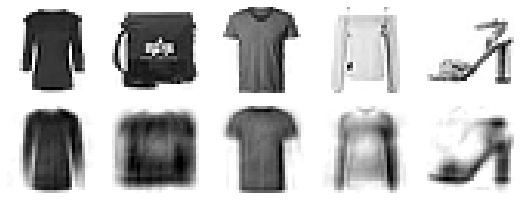

In [13]:
import numpy as np

def plot_reconstructions(model, images=X_valid, n_images=5):
    reconstructions = np.clip(model.predict(images[:n_images]), 0, 1)
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plt.imshow(images[image_index], cmap="binary")
        plt.axis("off")
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plt.imshow(reconstructions[image_index], cmap="binary")
        plt.axis("off")

plot_reconstructions(stacked_ae)
save_fig("reconstruction_plot")  # extra code – saves the high res figure
plt.show()

The reconstructions look fuzzy, but remember that the images were compressed down to just 30 numbers, instead of 784.

## Visualizing the Fashion MNIST Dataset

In [14]:
from sklearn.manifold import TSNE

X_valid_compressed = stacked_encoder.predict(X_valid)
tsne = TSNE(init="pca", learning_rate="auto", random_state=42)
X_valid_2D = tsne.fit_transform(X_valid_compressed)

/Users/ageron/miniconda3/envs/homl3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


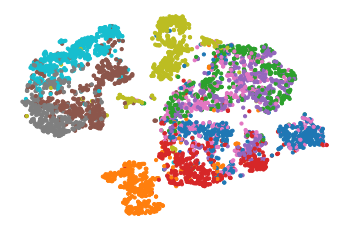

In [15]:
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap="tab10")
plt.show()

Let's make this diagram a bit prettier (adapted from [this Scikit-Learn example](https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html)):

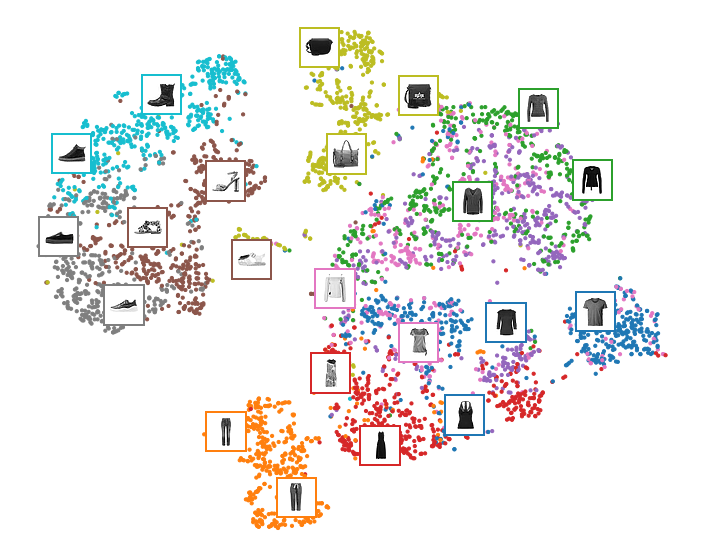

In [16]:
# extra code – beautifies the previous diagram for the book

import matplotlib as mpl

plt.figure(figsize=(10, 8))
cmap = plt.cm.tab10
Z = X_valid_2D
Z = (Z - Z.min()) / (Z.max() - Z.min())  # normalize to the 0-1 range
plt.scatter(Z[:, 0], Z[:, 1], c=y_valid, s=10, cmap=cmap)
image_positions = np.array([[1., 1.]])
for index, position in enumerate(Z):
    dist = ((position - image_positions) ** 2).sum(axis=1)
    if dist.min() > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(X_valid[index], cmap="binary"),
            position, bboxprops={"edgecolor": cmap(y_valid[index]), "lw": 2})
        plt.gca().add_artist(imagebox)

plt.axis("off")
save_fig("fashion_mnist_visualization_plot")
plt.show()

## Tying weights

It is common to tie the weights of the encoder and the decoder, by simply using the transpose of the encoder's weights as the decoder weights. For this, we need to use a custom layer.

In [17]:
class DenseTranspose(tf.keras.layers.Layer):
    def __init__(self, dense, activation=None, **kwargs):
        super().__init__(**kwargs)
        self.dense = dense
        self.activation = tf.keras.activations.get(activation)

    def build(self, batch_input_shape):
        self.biases = self.add_weight(name="bias",
                                      shape=self.dense.input_shape[-1],
                                      initializer="zeros")
        super().build(batch_input_shape)

    def call(self, inputs):
        Z = tf.matmul(inputs, self.dense.weights[0], transpose_b=True)
        return self.activation(Z + self.biases)

In [18]:
tf.random.set_seed(42)  # extra code – ensures reproducibility on CPU

dense_1 = tf.keras.layers.Dense(100, activation="relu")
dense_2 = tf.keras.layers.Dense(30, activation="relu")

tied_encoder = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    dense_1,
    dense_2
])

tied_decoder = tf.keras.Sequential([
    DenseTranspose(dense_2, activation="relu"),
    DenseTranspose(dense_1),
    tf.keras.layers.Reshape([28, 28])
])

tied_ae = tf.keras.Sequential([tied_encoder, tied_decoder])

# extra code – compiles and fits the model
tied_ae.compile(loss="mse", optimizer="nadam")
history = tied_ae.fit(X_train, X_train, epochs=10,
                      validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.0246 - val_loss: 0.0185
Epoch 2/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.0169 - val_loss: 0.0161
Epoch 3/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0155 - val_loss: 0.0151
Epoch 4/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0148 - val_loss: 0.0146
Epoch 5/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.0142 - val_loss: 0.0141
Epoch 6/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.0138 - val_loss: 0.0138
Epoch 7/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0136 - val_loss: 0.0136
Epoch 8/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0134 - val_loss: 0.0137
Epoch 9/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0133 - val_loss: 0.0134
Epoch 10/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.013

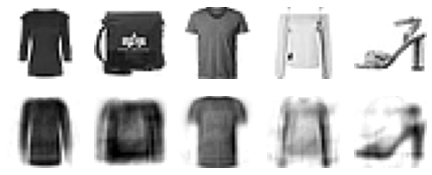

In [19]:
# extra code – plots reconstructions
plot_reconstructions(tied_ae)
plt.show()

## Extra Material – Training one Autoencoder at a Time

In [20]:
def train_autoencoder(n_neurons, X_train, X_valid, n_epochs=10,
                      output_activation=None):
    n_inputs = X_train.shape[-1]
    encoder = tf.keras.layers.Dense(n_neurons, activation="relu")
    decoder = tf.keras.layers.Dense(n_inputs, activation=output_activation)
    autoencoder = tf.keras.Sequential([encoder, decoder])
    autoencoder.compile(loss="mse", optimizer="nadam")
    autoencoder.fit(X_train, X_train, epochs=n_epochs,
                    validation_data=(X_valid, X_valid))
    return encoder, decoder, encoder(X_train), encoder(X_valid)

In [21]:
tf.random.set_seed(42)

X_train_flat = tf.keras.layers.Flatten()(X_train)
X_valid_flat = tf.keras.layers.Flatten()(X_valid)
enc1, dec1, X_train_enc1, X_valid_enc1 = train_autoencoder(
    100, X_train_flat, X_valid_flat)
enc2, dec2, _, _ = train_autoencoder(
    30, X_train_enc1, X_valid_enc1, output_activation="relu")

Epoch 1/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.0202 - val_loss: 0.0153
Epoch 2/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.0120 - val_loss: 0.0115
Epoch 3/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.0106 - val_loss: 0.0111
Epoch 4/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.0099 - val_loss: 0.0097
Epoch 5/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.0096 - val_loss: 0.0093
Epoch 6/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.0093 - val_loss: 0.0091
Epoch 7/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.0092 - val_loss: 0.0090
Epoch 8/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.0090 - val_loss: 0.0098
Epoch 9/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.0090 - val_loss: 0.0089
Epoch 10/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.008

In [22]:
stacked_ae_1_by_1 = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    enc1, enc2, dec2, dec1,
    tf.keras.layers.Reshape([28, 28])
])

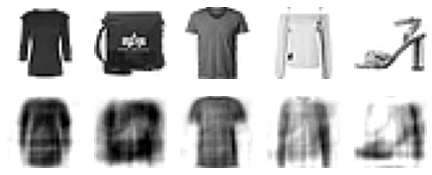

In [23]:
plot_reconstructions(stacked_ae_1_by_1)
plt.show()

If needed, we can then continue training the full stacked autoencoder for a few epochs:

In [24]:
stacked_ae_1_by_1.compile(loss="mse", optimizer="nadam")
history = stacked_ae_1_by_1.fit(X_train, X_train, epochs=5,
                                validation_data=(X_valid, X_valid))

Epoch 1/5
1719/1719 [==============================] - 8s 4ms/step - loss: 0.0173 - val_loss: 0.0161
Epoch 2/5
1719/1719 [==============================] - 7s 4ms/step - loss: 0.0151 - val_loss: 0.0144
Epoch 3/5
1719/1719 [==============================] - 7s 4ms/step - loss: 0.0142 - val_loss: 0.0141
Epoch 4/5
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0137 - val_loss: 0.0136
Epoch 5/5
1719/1719 [==============================] - 6s 3ms/step - loss: 0.0133 - val_loss: 0.0133


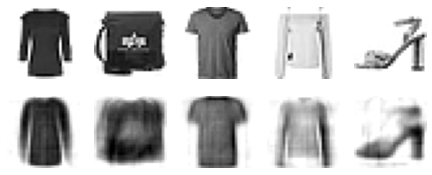

In [25]:
plot_reconstructions(stacked_ae_1_by_1)
plt.show()

## Convolutional Autoencoders

Let's build a stacked Autoencoder with 3 hidden layers and 1 output layer (i.e., 2 stacked Autoencoders).

In [26]:
tf.random.set_seed(42)  # extra code – ensures reproducibility on CPU

conv_encoder = tf.keras.Sequential([
    tf.keras.layers.Reshape([28, 28, 1]),
    tf.keras.layers.Conv2D(16, 3, padding="same", activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=2),  # output: 14 × 14 x 16
    tf.keras.layers.Conv2D(32, 3, padding="same", activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=2),  # output: 7 × 7 x 32
    tf.keras.layers.Conv2D(64, 3, padding="same", activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=2),  # output: 3 × 3 x 64
    tf.keras.layers.Conv2D(30, 3, padding="same", activation="relu"),
    tf.keras.layers.GlobalAvgPool2D()  # output: 30
])
conv_decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(3 * 3 * 16),
    tf.keras.layers.Reshape((3, 3, 16)),
    tf.keras.layers.Conv2DTranspose(32, 3, strides=2, activation="relu"),
    tf.keras.layers.Conv2DTranspose(16, 3, strides=2, padding="same",
                                    activation="relu"),
    tf.keras.layers.Conv2DTranspose(1, 3, strides=2, padding="same"),
    tf.keras.layers.Reshape([28, 28])
])
conv_ae = tf.keras.Sequential([conv_encoder, conv_decoder])

# extra code – compiles and fits the model
conv_ae.compile(loss="mse", optimizer="nadam")
history = conv_ae.fit(X_train, X_train, epochs=10,
                      validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 64s 37ms/step - loss: 0.0335 - val_loss: 0.0235
Epoch 2/10
1719/1719 [==============================] - 62s 36ms/step - loss: 0.0209 - val_loss: 0.0194
Epoch 3/10
1719/1719 [==============================] - 64s 37ms/step - loss: 0.0179 - val_loss: 0.0178
Epoch 4/10
1719/1719 [==============================] - 61s 36ms/step - loss: 0.0162 - val_loss: 0.0155
Epoch 5/10
1719/1719 [==============================] - 62s 36ms/step - loss: 0.0150 - val_loss: 0.0144
Epoch 6/10
1719/1719 [==============================] - 57s 33ms/step - loss: 0.0141 - val_loss: 0.0137
Epoch 7/10
1719/1719 [==============================] - 61s 36ms/step - loss: 0.0134 - val_loss: 0.0132
Epoch 8/10
1719/1719 [==============================] - 63s 37ms/step - loss: 0.0129 - val_loss: 0.0128
Epoch 9/10
1719/1719 [==============================] - 63s 36ms/step - loss: 0.0125 - val_loss: 0.0126
Epoch 10/10
1719/1719 [==============================] - 59s 34m

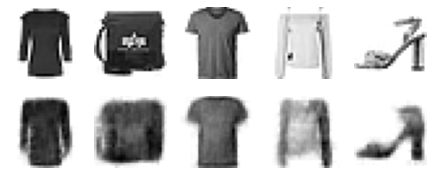

In [27]:
# extra code – shows the reconstructions
plot_reconstructions(conv_ae)
plt.show()

# Extra Material – Recurrent Autoencoders

Let's treat each Fashion MNIST image as a sequence of 28 vectors, each with 28 dimensions:

In [28]:
tf.random.set_seed(42)

recurrent_encoder = tf.keras.Sequential([
    tf.keras.layers.LSTM(100, return_sequences=True),
    tf.keras.layers.LSTM(30)
])
recurrent_decoder = tf.keras.Sequential([
    tf.keras.layers.RepeatVector(28),
    tf.keras.layers.LSTM(100, return_sequences=True),
    tf.keras.layers.Dense(28)
])
recurrent_ae = tf.keras.Sequential([recurrent_encoder, recurrent_decoder])
recurrent_ae.compile(loss="mse", optimizer="nadam")

In [29]:
history = recurrent_ae.fit(X_train, X_train, epochs=10,
                           validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 224s 128ms/step - loss: 0.0293 - val_loss: 0.0208
Epoch 2/10
1719/1719 [==============================] - 242s 141ms/step - loss: 0.0190 - val_loss: 0.0171
Epoch 3/10
1719/1719 [==============================] - 253s 147ms/step - loss: 0.0162 - val_loss: 0.0172
Epoch 4/10
1719/1719 [==============================] - 286s 166ms/step - loss: 0.0146 - val_loss: 0.0137
Epoch 5/10
1719/1719 [==============================] - 224s 130ms/step - loss: 0.0134 - val_loss: 0.0130
Epoch 6/10
1719/1719 [==============================] - 211s 123ms/step - loss: 0.0126 - val_loss: 0.0121
Epoch 7/10
1719/1719 [==============================] - 239s 139ms/step - loss: 0.0119 - val_loss: 0.0120
Epoch 8/10
1719/1719 [==============================] - 273s 159ms/step - loss: 0.0113 - val_loss: 0.0112
Epoch 9/10
1719/1719 [==============================] - 256s 149ms/step - loss: 0.0109 - val_loss: 0.0111
Epoch 10/10
1719/1719 [=======================

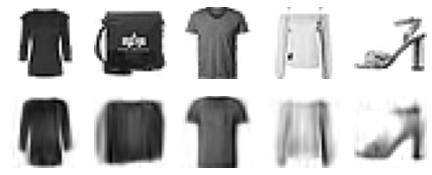

In [30]:
plot_reconstructions(recurrent_ae)
plt.show()

# Denoising Autoencoders

Using dropout:

In [31]:
tf.random.set_seed(42)  # extra code – ensures reproducibility on CPU

dropout_encoder = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(30, activation="relu")
])
dropout_decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(28 * 28),
    tf.keras.layers.Reshape([28, 28])
])
dropout_ae = tf.keras.Sequential([dropout_encoder, dropout_decoder])

# extra code – compiles and fits the model
dropout_ae.compile(loss="mse", optimizer="nadam")
history = dropout_ae.fit(X_train, X_train, epochs=10,
                         validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 16s 9ms/step - loss: 0.0290 - val_loss: 0.0220
Epoch 2/10
1719/1719 [==============================] - 15s 9ms/step - loss: 0.0223 - val_loss: 0.0200
Epoch 3/10
1719/1719 [==============================] - 15s 9ms/step - loss: 0.0209 - val_loss: 0.0191
Epoch 4/10
1719/1719 [==============================] - 16s 9ms/step - loss: 0.0201 - val_loss: 0.0185
Epoch 5/10
1719/1719 [==============================] - 14s 8ms/step - loss: 0.0196 - val_loss: 0.0180
Epoch 6/10
1719/1719 [==============================] - 14s 8ms/step - loss: 0.0193 - val_loss: 0.0178
Epoch 7/10
1719/1719 [==============================] - 15s 9ms/step - loss: 0.0190 - val_loss: 0.0174
Epoch 8/10
1719/1719 [==============================] - 15s 9ms/step - loss: 0.0187 - val_loss: 0.0171
Epoch 9/10
1719/1719 [==============================] - 17s 10ms/step - loss: 0.0185 - val_loss: 0.0169
Epoch 10/10
1719/1719 [==============================] - 16s 9ms/step - 

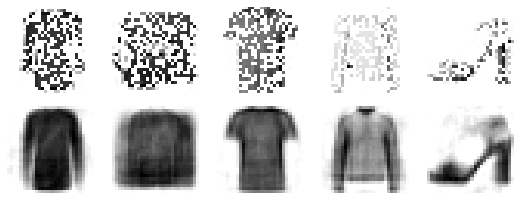

In [32]:
# extra code – this cell generates and saves Figure 17–9
tf.random.set_seed(42)
dropout = tf.keras.layers.Dropout(0.5)
plot_reconstructions(dropout_ae, dropout(X_valid, training=True))
save_fig("dropout_denoising_plot")
plt.show()

If you want, you can try replacing the `Dropout` layer with `tf.keras.layers.GaussianNoise(0.2)`.

# Sparse Autoencoder

Let's use the sigmoid activation function in the coding layer. Let's also add $\ell_1$ regularization to it: to do this, we add an `ActivityRegularization` layer after the coding layer. Alternatively, we could add `activity_regularizer=tf.keras.regularizers.l1(1e-4)` to the coding layer itself.

In [33]:
tf.random.set_seed(42)  # extra code – ensures reproducibility on CPU

sparse_l1_encoder = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(300, activation="sigmoid"),
    tf.keras.layers.ActivityRegularization(l1=1e-4)
])
sparse_l1_decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(28 * 28),
    tf.keras.layers.Reshape([28, 28])
])
sparse_l1_ae = tf.keras.Sequential([sparse_l1_encoder, sparse_l1_decoder])

# extra code – compiles and fits the model
sparse_l1_ae.compile(loss="mse", optimizer="nadam")
history = sparse_l1_ae.fit(X_train, X_train, epochs=10,
                           validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 21s 12ms/step - loss: 0.0294 - val_loss: 0.0204
Epoch 2/10
1719/1719 [==============================] - 21s 12ms/step - loss: 0.0184 - val_loss: 0.0176
Epoch 3/10
1719/1719 [==============================] - 21s 12ms/step - loss: 0.0159 - val_loss: 0.0152
Epoch 4/10
1719/1719 [==============================] - 22s 13ms/step - loss: 0.0145 - val_loss: 0.0139
Epoch 5/10
1719/1719 [==============================] - 21s 12ms/step - loss: 0.0134 - val_loss: 0.0131
Epoch 6/10
1719/1719 [==============================] - 21s 12ms/step - loss: 0.0128 - val_loss: 0.0124
Epoch 7/10
1719/1719 [==============================] - 20s 12ms/step - loss: 0.0122 - val_loss: 0.0120
Epoch 8/10
1719/1719 [==============================] - 18s 11ms/step - loss: 0.0118 - val_loss: 0.0119
Epoch 9/10
1719/1719 [==============================] - 18s 10ms/step - loss: 0.0114 - val_loss: 0.0114
Epoch 10/10
1719/1719 [==============================] - 19s 11m

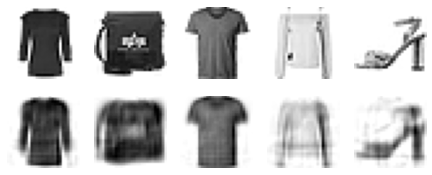

In [34]:
# extra code – shows the reconstructions
plot_reconstructions(sparse_l1_ae)
plt.show()

Let's plot the KL Divergence loss, versus the MAE and MSE:

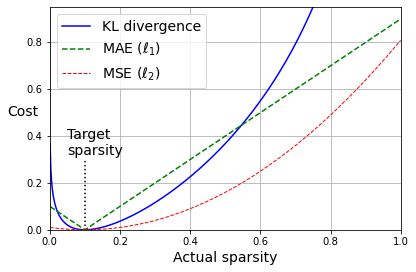

In [35]:
# extra code – this cell generates and saves Figure 17–10
p = 0.1
q = np.linspace(0.001, 0.999, 500)
kl_div = p * np.log(p / q) + (1 - p) * np.log((1 - p) / (1 - q))
mse = (p - q) ** 2
mae = np.abs(p - q)
plt.plot([p, p], [0, 0.3], "k:")
plt.text(0.05, 0.32, "Target\nsparsity", fontsize=14)
plt.plot(q, kl_div, "b-", label="KL divergence")
plt.plot(q, mae, "g--", label=r"MAE ($\ell_1$)")
plt.plot(q, mse, "r--", linewidth=1, label=r"MSE ($\ell_2$)")
plt.legend(loc="upper left", fontsize=14)
plt.xlabel("Actual sparsity")
plt.ylabel("Cost", rotation=0)
plt.axis([0, 1, 0, 0.95])
plt.grid(True)
save_fig("sparsity_loss_plot")

Let's define a custom regularizer for KL-Divergence regularization:

In [36]:
kl_divergence = tf.keras.losses.kullback_leibler_divergence

class KLDivergenceRegularizer(tf.keras.regularizers.Regularizer):
    def __init__(self, weight, target):
        self.weight = weight
        self.target = target

    def __call__(self, inputs):
        mean_activities = tf.reduce_mean(inputs, axis=0)
        return self.weight * (
            kl_divergence(self.target, mean_activities) +
            kl_divergence(1. - self.target, 1. - mean_activities))

Now let's use this regularizer to push the model to have about 10% sparsity in the coding layer:

In [37]:
tf.random.set_seed(42)  # extra code – ensures reproducibility on CPU

kld_reg = KLDivergenceRegularizer(weight=5e-3, target=0.1)
sparse_kl_encoder = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(300, activation="sigmoid",
                          activity_regularizer=kld_reg)
])
sparse_kl_decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(28 * 28),
    tf.keras.layers.Reshape([28, 28])
])
sparse_kl_ae = tf.keras.Sequential([sparse_kl_encoder, sparse_kl_decoder])

# extra code – compiles and fits the model
sparse_kl_ae.compile(loss="mse", optimizer="nadam")
history = sparse_kl_ae.fit(X_train, X_train, epochs=10,
                           validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 20s 11ms/step - loss: 0.0273 - val_loss: 0.0186
Epoch 2/10
1719/1719 [==============================] - 21s 12ms/step - loss: 0.0167 - val_loss: 0.0148
Epoch 3/10
1719/1719 [==============================] - 20s 11ms/step - loss: 0.0141 - val_loss: 0.0142
Epoch 4/10
1719/1719 [==============================] - 18s 11ms/step - loss: 0.0126 - val_loss: 0.0121
Epoch 5/10
1719/1719 [==============================] - 17s 10ms/step - loss: 0.0116 - val_loss: 0.0116
Epoch 6/10
1719/1719 [==============================] - 17s 10ms/step - loss: 0.0110 - val_loss: 0.0106
Epoch 7/10
1719/1719 [==============================] - 18s 10ms/step - loss: 0.0105 - val_loss: 0.0103
Epoch 8/10
1719/1719 [==============================] - 19s 11ms/step - loss: 0.0102 - val_loss: 0.0108
Epoch 9/10
1719/1719 [==============================] - 20s 12ms/step - loss: 0.0100 - val_loss: 0.0104
Epoch 10/10
1719/1719 [==============================] - 20s 12m

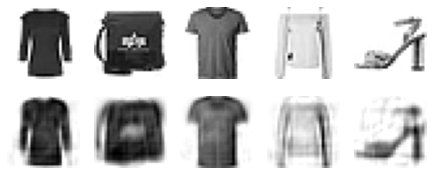

In [38]:
# extra code – shows the reconstructions
plot_reconstructions(sparse_kl_ae)
plt.show()

# Variational Autoencoder

In [39]:
class Sampling(tf.keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return tf.random.normal(tf.shape(log_var)) * tf.exp(log_var / 2) + mean 

In [40]:
tf.random.set_seed(42)  # extra code – ensures reproducibility on CPU

codings_size = 10

inputs = tf.keras.layers.Input(shape=[28, 28])
Z = tf.keras.layers.Flatten()(inputs)
Z = tf.keras.layers.Dense(150, activation="relu")(Z)
Z = tf.keras.layers.Dense(100, activation="relu")(Z)
codings_mean = tf.keras.layers.Dense(codings_size)(Z)  # μ
codings_log_var = tf.keras.layers.Dense(codings_size)(Z)  # γ
codings = Sampling()([codings_mean, codings_log_var])
variational_encoder = tf.keras.Model(
    inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])

In [41]:
decoder_inputs = tf.keras.layers.Input(shape=[codings_size])
x = tf.keras.layers.Dense(100, activation="relu")(decoder_inputs)
x = tf.keras.layers.Dense(150, activation="relu")(x)
x = tf.keras.layers.Dense(28 * 28)(x)
outputs = tf.keras.layers.Reshape([28, 28])(x)
variational_decoder = tf.keras.Model(inputs=[decoder_inputs], outputs=[outputs])

In [42]:
_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae = tf.keras.Model(inputs=[inputs], outputs=[reconstructions])

In [43]:
latent_loss = -0.5 * tf.reduce_sum(
    1 + codings_log_var - tf.exp(codings_log_var) - tf.square(codings_mean),
    axis=-1)
variational_ae.add_loss(tf.reduce_mean(latent_loss) / 784.)

In [44]:
variational_ae.compile(loss="mse", optimizer="nadam")
history = variational_ae.fit(X_train, X_train, epochs=25, batch_size=128,
                             validation_data=(X_valid, X_valid))

Epoch 1/25
430/430 [==============================] - 9s 19ms/step - loss: 0.0513 - val_loss: 0.0398
Epoch 2/25
430/430 [==============================] - 8s 19ms/step - loss: 0.0376 - val_loss: 0.0369
Epoch 3/25
430/430 [==============================] - 7s 17ms/step - loss: 0.0356 - val_loss: 0.0351
Epoch 4/25
430/430 [==============================] - 8s 18ms/step - loss: 0.0345 - val_loss: 0.0343
Epoch 5/25
430/430 [==============================] - 8s 19ms/step - loss: 0.0338 - val_loss: 0.0339
Epoch 6/25
430/430 [==============================] - 8s 18ms/step - loss: 0.0333 - val_loss: 0.0333
Epoch 7/25
430/430 [==============================] - 7s 17ms/step - loss: 0.0329 - val_loss: 0.0336
Epoch 8/25
430/430 [==============================] - 7s 16ms/step - loss: 0.0327 - val_loss: 0.0327
Epoch 9/25
430/430 [==============================] - 7s 17ms/step - loss: 0.0324 - val_loss: 0.0326
Epoch 10/25
430/430 [==============================] - 8s 19ms/step - loss: 0.0322 - val_lo

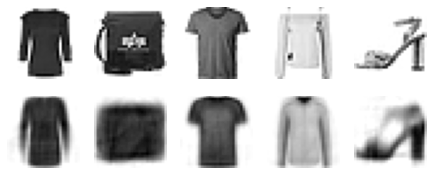

In [45]:
plot_reconstructions(variational_ae)
plt.show()

## Generate Fashion Images

Let's generate a few random codings and decode them:

In [46]:
tf.random.set_seed(42)  # extra code – ensures reproducibility on CPU

codings = tf.random.normal(shape=[3 * 7, codings_size])
images = variational_decoder(codings).numpy()

Now let's plot these images:

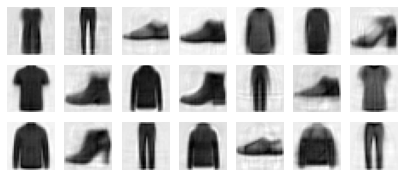

In [47]:
# extra code – this cells generates and saves Figure 17-12

def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = images.squeeze(axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

plot_multiple_images(images, 7)
save_fig("vae_generated_images_plot", tight_layout=False)
plt.show()

Now let's perform semantic interpolation between 2 images:

In [48]:
tf.random.set_seed(42)  # extra code – ensures reproducibility on CPU

codings = np.zeros([7, codings_size])
codings[:, 3] = np.linspace(-0.8, 0.8, 7)  # axis 3 looks best in this case
images = variational_decoder(codings).numpy()

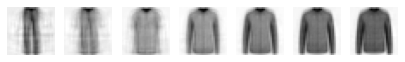

In [49]:
# extra code – this cell generates and saves Figure 17–13
plot_multiple_images(images)
save_fig("semantic_interpolation_plot", tight_layout=False)
plt.show()

# Generative Adversarial Networks

In [50]:
tf.random.set_seed(42)  # extra code – ensures reproducibility on CPU

codings_size = 30

Dense = tf.keras.layers.Dense
generator = tf.keras.Sequential([
    Dense(100, activation="relu", kernel_initializer="he_normal"),
    Dense(150, activation="relu", kernel_initializer="he_normal"),
    Dense(28 * 28, activation="sigmoid"),
    tf.keras.layers.Reshape([28, 28])
])
discriminator = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    Dense(150, activation="relu", kernel_initializer="he_normal"),
    Dense(100, activation="relu", kernel_initializer="he_normal"),
    Dense(1, activation="sigmoid")
])
gan = tf.keras.Sequential([generator, discriminator])

In [51]:
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

In [52]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

Epoch 1/50


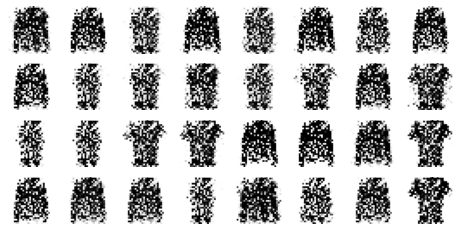

Epoch 2/50


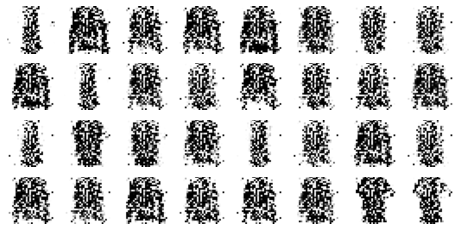

Epoch 3/50


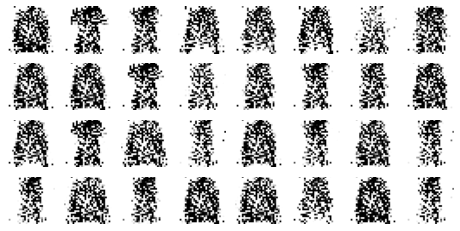

<<44 more epochs>>
Epoch 48/50


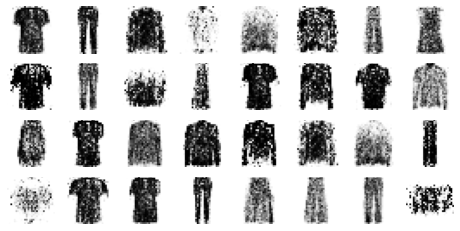

Epoch 49/50


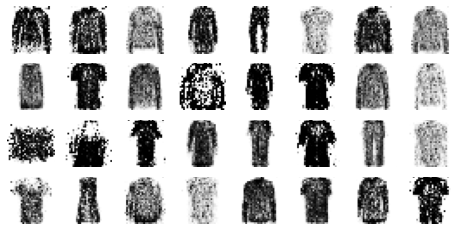

Epoch 50/50


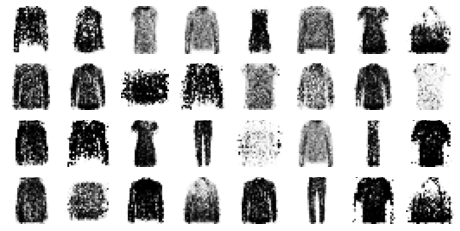

In [53]:
def train_gan(gan, dataset, batch_size, codings_size, n_epochs):
    generator, discriminator = gan.layers
    for epoch in range(n_epochs):
        print(f"Epoch {epoch + 1}/{n_epochs}")  # extra code
        for X_batch in dataset:
            # phase 1 - training the discriminator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            generated_images = generator(noise)
            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            discriminator.train_on_batch(X_fake_and_real, y1)
            # phase 2 - training the generator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            y2 = tf.constant([[1.]] * batch_size)
            gan.train_on_batch(noise, y2)
        # extra code — plot images during training
        plot_multiple_images(generated_images.numpy(), 8)
        plt.show()

train_gan(gan, dataset, batch_size, codings_size, n_epochs=50)

In [54]:
tf.random.set_seed(42)  # extra code – ensures reproducibility on CPU

codings = tf.random.normal(shape=[batch_size, codings_size])
generated_images = generator.predict(codings)

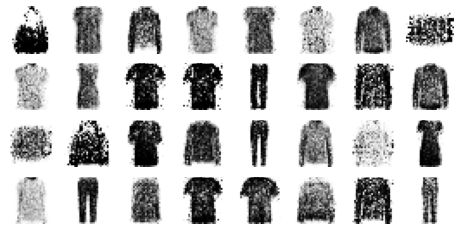

In [55]:
# extra code – this cell generates and saves Figure 17–15
plot_multiple_images(generated_images, 8)
save_fig("gan_generated_images_plot", tight_layout=False)
plt.show()

# Deep Convolutional GAN

In [56]:
tf.random.set_seed(42)  # extra code – ensures reproducibility on CPU

codings_size = 100

generator = tf.keras.Sequential([
    tf.keras.layers.Dense(7 * 7 * 128),
    tf.keras.layers.Reshape([7, 7, 128]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2DTranspose(64, kernel_size=5, strides=2,
                                    padding="same", activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2DTranspose(1, kernel_size=5, strides=2,
                                    padding="same", activation="tanh"),
])
discriminator = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64, kernel_size=5, strides=2, padding="same",
                        activation=tf.keras.layers.LeakyReLU(0.2)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Conv2D(128, kernel_size=5, strides=2, padding="same",
                        activation=tf.keras.layers.LeakyReLU(0.2)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation="sigmoid")
])
gan = tf.keras.Sequential([generator, discriminator])

In [57]:
# extra code – compiles the discrimator and the gan, as earlier
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

In [58]:
X_train_dcgan = X_train.reshape(-1, 28, 28, 1) * 2. - 1. # reshape and rescale

Epoch 1/50


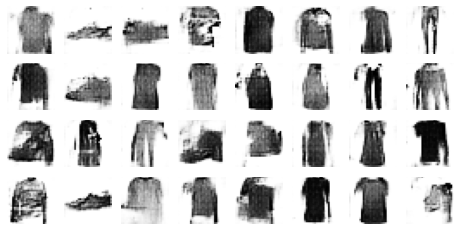

Epoch 2/50


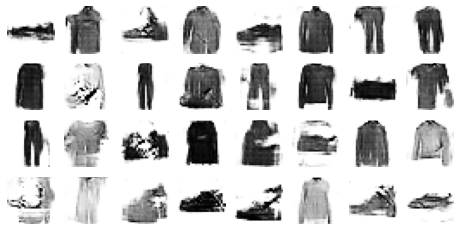

Epoch 3/50


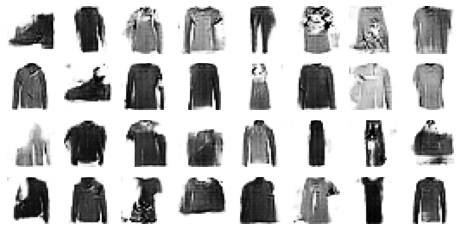

<<44 more epochs>>
Epoch 48/50


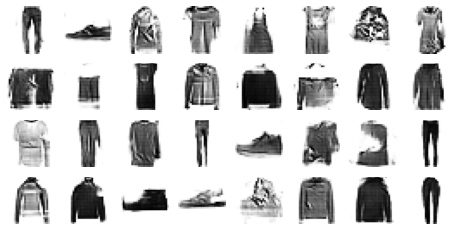

Epoch 49/50


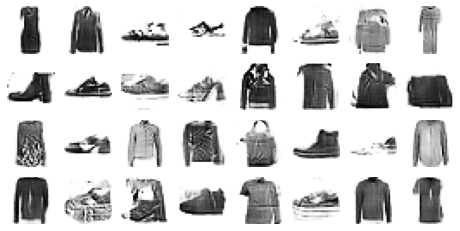

Epoch 50/50


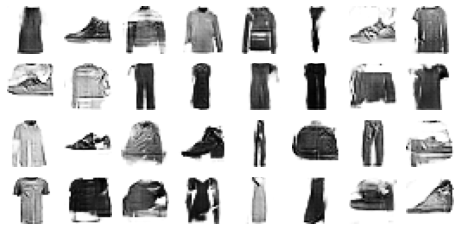

In [59]:
# extra code – generates the dataset and trains the GAN, just like earlier
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(X_train_dcgan)
dataset = dataset.shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)
train_gan(gan, dataset, batch_size, codings_size, n_epochs=50)

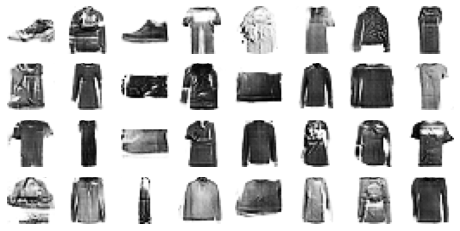

In [60]:
# extra code – this cell generates and saves Figure 17–16
tf.random.set_seed(42)
noise = tf.random.normal(shape=[batch_size, codings_size])
generated_images = generator.predict(noise)
plot_multiple_images(generated_images, 8)
save_fig("dcgan_generated_images_plot", tight_layout=False)

# Diffusion Models

Starting with an image from the dataset, at each time step $t$, the diffusion process adds Gaussian noise with mean 0 and variance $\beta_t$. The model is then trained to reverse that process. More specifically, given a noisy image produced by the forward process, and given the time $t$, the model is trained to predict the total noise that was added to the original image, scaled to variance 1.

The [DDPM paper](https://arxiv.org/abs/2006.11239) increased $\beta_t$ from $\beta_1$ = 0.0001 to $\beta_T = $0.02 ($T$ is the max step), but the [Improved DDPM paper](https://arxiv.org/pdf/2102.09672.pdf) suggested using the following $\cos^2(\ldots)$ schedule instead, which gradually decreases $\bar{\alpha_t} = \prod_{i=0}^{t} \alpha_i$ from 1 to 0, where $\alpha_t = 1 - \beta_t$:

In [61]:
def variance_schedule(T, s=0.008, max_beta=0.999):
    t = np.arange(T + 1)
    f = np.cos((t / T + s) / (1 + s) * np.pi / 2) ** 2
    alpha = np.clip(f[1:] / f[:-1], 1 - max_beta, 1)
    alpha = np.append(1, alpha).astype(np.float32)  # add α₀ = 1
    beta = 1 - alpha
    alpha_cumprod = np.cumprod(alpha)
    return alpha, alpha_cumprod, beta  # αₜ , α̅ₜ , βₜ for t = 0 to T

np.random.seed(42)  # extra code – for reproducibility
T = 4000
alpha, alpha_cumprod, beta = variance_schedule(T)

In the DDPM paper, the authors used $T = 1,000$, while in the Improved DDPM, they bumped this up to $T = 4,000$, so we use this value. The variable `alpha` is a vector containing $\alpha_0, \alpha_1, ..., \alpha_T$. The variable `alpha_cumprod` is a vector containing $\bar{\alpha_0}, \bar{\alpha_1}, ..., \bar{\alpha_T}$.

Let's plot `alpha_cumprod`:

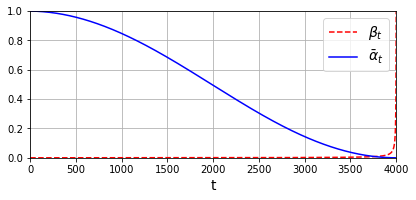

In [62]:
# extra code – this cell generates and saves Figure 17–21
plt.figure(figsize=(6, 3))
plt.plot(beta, "r--", label=r"$\beta_t$")
plt.plot(alpha_cumprod, "b", label=r"$\bar{\alpha}_t$")
plt.axis([0, T, 0, 1])
plt.grid(True)
plt.xlabel(r"t")
plt.legend()
save_fig("variance_schedule_plot")
plt.show()

The `prepare_batch()` function takes a batch of images and adds noise to each of them, using a different random time between 1 and $T$ for each image, and it returns a tuple containing the inputs and the targets:

* The inputs are a `dict` containing the noisy images and the corresponding times. The function uses equation (4) from the DDPM paper to compute the noisy images in one shot, directly from the original images. It's a shortcut for the forward diffusion process.
* The target is the noise that was used to produce the noisy images.

In [63]:
def prepare_batch(X):
    X = tf.cast(X[..., tf.newaxis], tf.float32) * 2 - 1  # scale from –1 to +1
    X_shape = tf.shape(X)
    t = tf.random.uniform([X_shape[0]], minval=1, maxval=T + 1, dtype=tf.int32)
    alpha_cm = tf.gather(alpha_cumprod, t)
    alpha_cm = tf.reshape(alpha_cm, [X_shape[0]] + [1] * (len(X_shape) - 1))
    noise = tf.random.normal(X_shape)
    return {
        "X_noisy": alpha_cm ** 0.5 * X + (1 - alpha_cm) ** 0.5 * noise,
        "time": t,
    }, noise

Now let's prepare a `tf.data.Dataset` for training, and one for validation.

In [64]:
def prepare_dataset(X, batch_size=32, shuffle=False):
    ds = tf.data.Dataset.from_tensor_slices(X)
    if shuffle:
        ds = ds.shuffle(10_000)
    return ds.batch(batch_size).map(prepare_batch).prefetch(1)

tf.random.set_seed(43)  # extra code – ensures reproducibility on CPU
train_set = prepare_dataset(X_train, batch_size=32, shuffle=True)
valid_set = prepare_dataset(X_valid, batch_size=32)

As a quick sanity check, let's take a look at a few training samples, along with the corresponding noise to predict, and the original images (which we get by subtracting the appropriately scaled noise from the appropriately scaled noisy image):

Original images


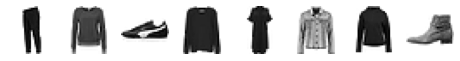

Time steps: [3405  312 3441 1991 2443 1657 3308 1151]
Noisy images


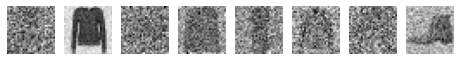

Noise to predict


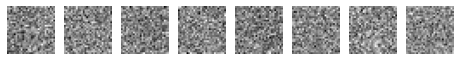

In [65]:
# extra code – just a quick sanity check

def subtract_noise(X_noisy, time, noise):
    X_shape = tf.shape(X_noisy)
    alpha_cm = tf.gather(alpha_cumprod, time)
    alpha_cm = tf.reshape(alpha_cm, [X_shape[0]] + [1] * (len(X_shape) - 1))
    return (X_noisy - (1 - alpha_cm) ** 0.5 * noise) / alpha_cm ** 0.5

X_dict, Y_noise = list(train_set.take(1))[0]  # get the first batch
X_original = subtract_noise(X_dict["X_noisy"], X_dict["time"], Y_noise)

print("Original images")
plot_multiple_images(X_original[:8].numpy())
plt.show()
print("Time steps:", X_dict["time"].numpy()[:8])
print("Noisy images")
plot_multiple_images(X_dict["X_noisy"][:8].numpy())
plt.show()
print("Noise to predict")
plot_multiple_images(Y_noise[:8].numpy())
plt.show()

Now we're ready to build the diffusion model itself. It will need to process both images and times. We will encode the times using a sinusoidal encoding, as suggested in the DDPM paper, just like in the [Attention is all you need](https://arxiv.org/abs/1706.03762) paper. Given a vector of _m_ integers representing time indices (integers), the layer returns an _m_ × _d_ matrix, where _d_ is the chosen embedding size.

In [66]:
# extra code – implements a custom time encoding layer

embed_size = 64

class TimeEncoding(tf.keras.layers.Layer):
    def __init__(self, T, embed_size, dtype=tf.float32, **kwargs):
        super().__init__(dtype=dtype, **kwargs)
        assert embed_size % 2 == 0, "embed_size must be even"
        p, i = np.meshgrid(np.arange(T + 1), 2 * np.arange(embed_size // 2))
        t_emb = np.empty((T + 1, embed_size))
        t_emb[:, ::2] = np.sin(p / 10_000 ** (i / embed_size)).T
        t_emb[:, 1::2] = np.cos(p / 10_000 ** (i / embed_size)).T
        self.time_encodings = tf.constant(t_emb.astype(self.dtype))

    def call(self, inputs):
        return tf.gather(self.time_encodings, inputs)

Now let's build the model. In the Improved DDPM paper, they use a UNet model. We'll create a UNet-like model, that processes the image through `Conv2D` + `BatchNormalization` layers and skip connections, gradually downsampling the image (using `MaxPooling` layers with `strides=2`), then growing it back again (using `Upsampling2D` layers). Skip connections are also added across the downsampling part and the upsampling part. We also add the time encodings to the output of each block, after passing them through a `Dense` layer to resize them to the right dimension.

* **Note**: an image's time encoding is added to every pixel in the image, along the last axis (channels). So the number of units in the `Conv2D` layer must correspond to the embedding size, and we must reshape the `time_enc` tensor to add the width and height dimensions.
* This UNet implementation was inspired by keras.io's [image segmentation example](https://keras.io/examples/vision/oxford_pets_image_segmentation/), as well as from the [official diffusion models implementation](https://github.com/hojonathanho/diffusion/blob/master/diffusion_tf/models/unet.py). Compared to the first implementation, I added a few things, especially time encodings and skip connections across down/up parts. Compared to the second implementation, I removed a few things, especially the attention layers. It seemed like overkill for Fashion MNIST, but feel free to add them.

In [67]:
def build_diffusion_model():
    X_noisy = tf.keras.layers.Input(shape=[28, 28, 1], name="X_noisy")
    time_input = tf.keras.layers.Input(shape=[], dtype=tf.int32, name="time")
    time_enc = TimeEncoding(T, embed_size)(time_input)

    dim = 16
    Z = tf.keras.layers.ZeroPadding2D((3, 3))(X_noisy)
    Z = tf.keras.layers.Conv2D(dim, 3)(Z)
    Z = tf.keras.layers.BatchNormalization()(Z)
    Z = tf.keras.layers.Activation("relu")(Z)

    time = tf.keras.layers.Dense(dim)(time_enc)  # adapt time encoding
    Z = time[:, tf.newaxis, tf.newaxis, :] + Z  # add time data to every pixel

    skip = Z
    cross_skips = []  # skip connections across the down & up parts of the UNet

    for dim in (32, 64, 128):
        Z = tf.keras.layers.Activation("relu")(Z)
        Z = tf.keras.layers.SeparableConv2D(dim, 3, padding="same")(Z)
        Z = tf.keras.layers.BatchNormalization()(Z)

        Z = tf.keras.layers.Activation("relu")(Z)
        Z = tf.keras.layers.SeparableConv2D(dim, 3, padding="same")(Z)
        Z = tf.keras.layers.BatchNormalization()(Z)

        cross_skips.append(Z)
        Z = tf.keras.layers.MaxPooling2D(3, strides=2, padding="same")(Z)
        skip_link = tf.keras.layers.Conv2D(dim, 1, strides=2,
                                           padding="same")(skip)
        Z = tf.keras.layers.add([Z, skip_link])

        time = tf.keras.layers.Dense(dim)(time_enc)
        Z = time[:, tf.newaxis, tf.newaxis, :] + Z
        skip = Z

    for dim in (64, 32, 16):
        Z = tf.keras.layers.Activation("relu")(Z)
        Z = tf.keras.layers.Conv2DTranspose(dim, 3, padding="same")(Z)
        Z = tf.keras.layers.BatchNormalization()(Z)

        Z = tf.keras.layers.Activation("relu")(Z)
        Z = tf.keras.layers.Conv2DTranspose(dim, 3, padding="same")(Z)
        Z = tf.keras.layers.BatchNormalization()(Z)

        Z = tf.keras.layers.UpSampling2D(2)(Z)

        skip_link = tf.keras.layers.UpSampling2D(2)(skip)
        skip_link = tf.keras.layers.Conv2D(dim, 1, padding="same")(skip_link)
        Z = tf.keras.layers.add([Z, skip_link])

        time = tf.keras.layers.Dense(dim)(time_enc)
        Z = time[:, tf.newaxis, tf.newaxis, :] + Z
        Z = tf.keras.layers.concatenate([Z, cross_skips.pop()], axis=-1)
        skip = Z

    outputs = tf.keras.layers.Conv2D(1, 3, padding="same")(Z)[:, 2:-2, 2:-2]
    return tf.keras.Model(inputs=[X_noisy, time_input], outputs=[outputs])

Let's train the model!

In [68]:
tf.random.set_seed(42)  # extra code – ensures reproducibility on the CPU
model = build_diffusion_model()
model.compile(loss=tf.keras.losses.Huber(), optimizer="nadam")

# extra code – adds a ModelCheckpoint callback
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("my_diffusion_model",
                                                   save_best_only=True)

history = model.fit(train_set, validation_data=valid_set, epochs=100,
                    callbacks=[checkpoint_cb])  # extra code

Epoch 1/100


INFO:tensorflow:Assets written to: my_diffusion_model/assets


1719/1719 [==============================] - 347s 199ms/step - loss: 0.1120 - val_loss: 0.0719
Epoch 2/100


INFO:tensorflow:Assets written to: my_diffusion_model/assets


1719/1719 [==============================] - 352s 205ms/step - loss: 0.0649 - val_loss: 0.0589
Epoch 3/100


INFO:tensorflow:Assets written to: my_diffusion_model/assets


1719/1719 [==============================] - 358s 208ms/step - loss: 0.0550 - val_loss: 0.0539
<<94 more epochs>>
Epoch 98/100
1719/1719 [==============================] - 351s 204ms/step - loss: 0.0377 - val_loss: 0.0375
Epoch 99/100
1719/1719 [==============================] - 407s 237ms/step - loss: 0.0376 - val_loss: 0.0379
Epoch 100/100
1719/1719 [==============================] - 418s 243ms/step - loss: 0.0376 - val_loss: 0.0379


Now that the model is trained, we can use it to generate new images. For this, we just generate Gaussian noise, and pretend this is the result of the diffusion process, and we're at time $T$. Then we use the model to predict the image at time $T - 1$, then we call it again to get $T - 2$, and so on, removing a bit of noise at each step. At the end, we get an image that looks like it's from the Fashion MNIST dataset. The equation for this reverse process is at the top of page 4 in the DDPM paper (step 4 in algorithm 2).

In [69]:
def generate(model, batch_size=32):
    X = tf.random.normal([batch_size, 28, 28, 1])
    for t in range(T - 1, 0, -1):
        print(f"\rt = {t}", end=" ")  # extra code – show progress
        noise = (tf.random.normal if t > 1 else tf.zeros)(tf.shape(X))
        X_noise = model({"X_noisy": X, "time": tf.constant([t] * batch_size)})
        X = (
            1 / alpha[t] ** 0.5
            * (X - beta[t] / (1 - alpha_cumprod[t]) ** 0.5 * X_noise)
            + (1 - alpha[t]) ** 0.5 * noise
        )
    return X

tf.random.set_seed(42)  # extra code – ensures reproducibility on the CPU
X_gen = generate(model)  # generated images

t = 1    

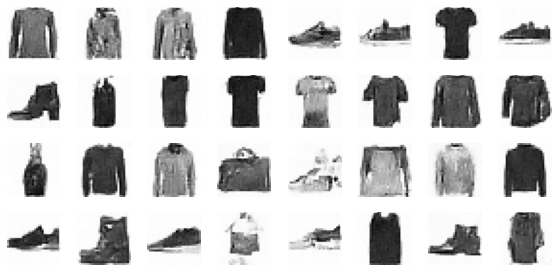

In [70]:
plot_multiple_images(X_gen.numpy(), 8)
save_fig("ddpm_generated_images_plot")
plt.show()

Some of these images are really convincing! Compared to GANs, diffusion models tend to generate more diverse images, and they have surpassed GANs in image quality. Moreover, training is much more stable. However, generating images takes *much* longer.

# Extra Material – Hashing Using a Binary Autoencoder

Let's train an autoencoder where the encoder has a 16-neuron output layer, using the sigmoid activation function, and heavy Gaussian noise just before it. During training, the noise layer will encourage the previous layer to output large values, since small values will just be crushed by the noise. In turn, this means that the output layer will output values close to 0 or 1, thanks to the sigmoid activation function. Once we round the output values to 0s and 1s, we get a 16-bit "semantic" hash. If everything works well, images that look alike will have the same hash. This can be very useful for search engines: for example, if we store each image on a server identified by the image's semantic hash, then all similar images will end up on the same server. Users of the search engine can then provide an image to search for, and the search engine will compute the image's hash using the encoder, and quickly return all the images on the server identified by that hash.

In [71]:
tf.random.set_seed(42)

hashing_encoder = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.GaussianNoise(15.),
    tf.keras.layers.Dense(16, activation="sigmoid"),
])
hashing_decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(28 * 28),
    tf.keras.layers.Reshape([28, 28])
])
hashing_ae = tf.keras.Sequential([hashing_encoder, hashing_decoder])
hashing_ae.compile(loss="mse", optimizer="nadam")
history = hashing_ae.fit(X_train, X_train, epochs=10,
                         validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.0543 - val_loss: 0.0574
Epoch 2/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.0426 - val_loss: 0.0485
Epoch 3/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.0392 - val_loss: 0.0428
Epoch 4/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.0372 - val_loss: 0.0404
Epoch 5/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.0360 - val_loss: 0.0379
Epoch 6/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.0352 - val_loss: 0.0363
Epoch 7/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.0345 - val_loss: 0.0365
Epoch 8/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.0339 - val_loss: 0.0359
Epoch 9/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.0334 - val_loss: 0.0350
Epoch 10/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.033

The autoencoder compresses the information so much (down to 16 bits!) that it's quite lossy, but that's okay, we're using it to produce semantic hashes, not to perfectly reconstruct the images:

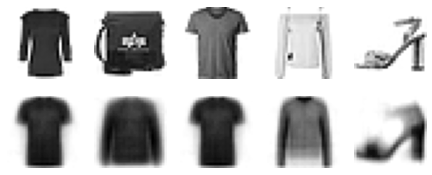

In [72]:
plot_reconstructions(hashing_ae)
plt.show()

Now let's see what the hashes look like for the first few images in the validation set:

In [73]:
hashes = hashing_encoder.predict(X_valid).round().astype(np.int32)
hashes *= np.array([[2 ** bit for bit in range(16)]])
hashes = hashes.sum(axis=1)
for h in hashes[:5]:
    print(f"{h:016b}")
print("...")

1110110110111011
1100110111111111
1110110110111011
1100011111110010
0000100001110101
...


Now let's find the most common image hashes in the validation set, and display a few images for each hash. In the following image, all the images on a given row have the same hash:

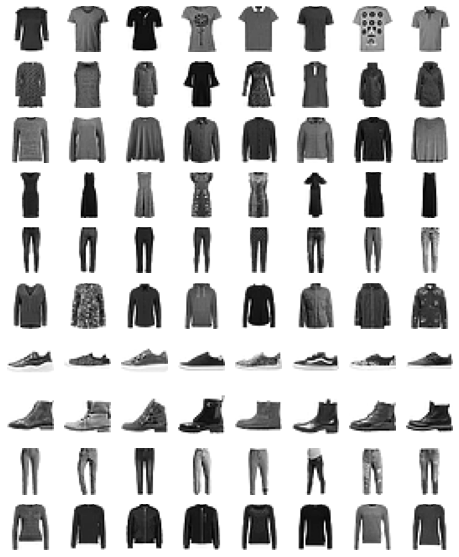

In [74]:
from collections import Counter

n_hashes = 10
n_images = 8

top_hashes = Counter(hashes).most_common(n_hashes)

plt.figure(figsize=(n_images, n_hashes))
for hash_index, (image_hash, hash_count) in enumerate(top_hashes):
    indices = (hashes == image_hash)
    for index, image in enumerate(X_valid[indices][:n_images]):
        plt.subplot(n_hashes, n_images, hash_index * n_images + index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

plt.show()

# Exercise Solutions

## 1. to 8.

1. Here are some of the main tasks that autoencoders are used for:
    * Feature extraction
    * Unsupervised pretraining
    * Dimensionality reduction
    * Generative models
    * Anomaly detection (an autoencoder is generally bad at reconstructing outliers)
2. If you want to train a classifier and you have plenty of unlabeled training data but only a few thousand labeled instances, then you could first train a deep autoencoder on the full dataset (labeled + unlabeled), then reuse its lower half for the classifier (i.e., reuse the layers up to the codings layer, included) and train the classifier using the labeled data. If you have little labeled data, you probably want to freeze the reused layers when training the classifier.
3. The fact that an autoencoder perfectly reconstructs its inputs does not necessarily mean that it is a good autoencoder; perhaps it is simply an overcomplete autoencoder that learned to copy its inputs to the codings layer and then to the outputs. In fact, even if the codings layer contained a single neuron, it would be possible for a very deep autoencoder to learn to map each training instance to a different coding (e.g., the first instance could be mapped to 0.001, the second to 0.002, the third to 0.003, and so on), and it could learn "by heart" to reconstruct the right training instance for each coding. It would perfectly reconstruct its inputs without really learning any useful pattern in the data. In practice such a mapping is unlikely to happen, but it illustrates the fact that perfect reconstructions are not a guarantee that the autoencoder learned anything useful. However, if it produces very bad reconstructions, then it is almost guaranteed to be a bad autoencoder. To evaluate the performance of an autoencoder, one option is to measure the reconstruction loss (e.g., compute the MSE, or the mean square of the outputs minus the inputs). Again, a high reconstruction loss is a good sign that the autoencoder is bad, but a low reconstruction loss is not a guarantee that it is good. You should also evaluate the autoencoder according to what it will be used for. For example, if you are using it for unsupervised pretraining of a classifier, then you should also evaluate the classifier's performance.
4. An undercomplete autoencoder is one whose codings layer is smaller than the input and output layers. If it is larger, then it is an overcomplete autoencoder. The main risk of an excessively undercomplete autoencoder is that it may fail to reconstruct the inputs. The main risk of an overcomplete autoencoder is that it may just copy the inputs to the outputs, without learning any useful features.
5. To tie the weights of an encoder layer and its corresponding decoder layer, you simply make the decoder weights equal to the transpose of the encoder weights. This reduces the number of parameters in the model by half, often making training converge faster with less training data and reducing the risk of overfitting the training set.
6. A generative model is a model capable of randomly generating outputs that resemble the training instances. For example, once trained successfully on the MNIST dataset, a generative model can be used to randomly generate realistic images of digits. The output distribution is typically similar to the training data. For example, since MNIST contains many images of each digit, the generative model would output roughly the same number of images of each digit. Some generative models can be parametrized—for example, to generate only some kinds of outputs. An example of a generative autoencoder is the variational autoencoder.
7. A generative adversarial network is a neural network architecture composed of two parts, the generator and the discriminator, which have opposing objectives. The generator's goal is to generate instances similar to those in the training set, to fool the discriminator. The discriminator must distinguish the real instances from the generated ones. At each training iteration, the discriminator is trained like a normal binary classifier, then the generator is trained to maximize the discriminator's error. GANs are used for advanced image processing tasks such as super resolution, colorization, image editing (replacing objects with realistic background), turning a simple sketch into a photorealistic image, or predicting the next frames in a video. They are also used to augment a dataset (to train other models), to generate other types of data (such as text, audio, and time series), and to identify the weaknesses in other models and strengthen them.
8. Training GANs is notoriously difficult, because of the complex dynamics between the generator and the discriminator. The biggest difficulty is mode collapse, where the generator produces outputs with very little diversity. Moreover, training can be terribly unstable: it may start out fine and then suddenly start oscillating or diverging, without any apparent reason. GANs are also very sensitive to the choice of hyperparameters.
9. Diffusion models are good at generating diverse and high quality images. They are also much easier to train than GANs. However, compared to GANs and VAEs, they are much slower when generating images, since they must go through each step in the reverse diffusion process.

## 10.
_Exercise: Try using a denoising autoencoder to pretrain an image classifier. You can use MNIST (the simplest option), or a more complex image dataset such as [CIFAR10](https://homl.info/122) if you want a bigger challenge. Regardless of the dataset you're using, follow these steps:_
* Split the dataset into a training set and a test set. Train a deep denoising autoencoder on the full training set.
* Check that the images are fairly well reconstructed. Visualize the images that most activate each neuron in the coding layer.
* Build a classification DNN, reusing the lower layers of the autoencoder. Train it using only 500 images from the training set. Does it perform better with or without pretraining?

In [75]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()
X_train = X_train / 255
X_test = X_test / 255

In [76]:
tf.random.set_seed(42)

denoising_encoder = tf.keras.Sequential([
    tf.keras.layers.GaussianNoise(0.1),
    tf.keras.layers.Conv2D(32, 3, padding="same", activation="relu"),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation="relu"),
])

In [77]:
denoising_decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(16 * 16 * 32, activation="relu"),
    tf.keras.layers.Reshape([16, 16, 32]),
    tf.keras.layers.Conv2DTranspose(filters=3, kernel_size=3, strides=2,
                                 padding="same", activation="sigmoid")
])

In [78]:
denoising_ae = tf.keras.Sequential([denoising_encoder, denoising_decoder])
denoising_ae.compile(loss="binary_crossentropy", optimizer="nadam",
                     metrics=["mse"])
history = denoising_ae.fit(X_train, X_train, epochs=10,
                           validation_data=(X_test, X_test))

Epoch 1/10
1563/1563 [==============================] - 165s 105ms/step - loss: 0.5931 - mse: 0.0184 - val_loss: 0.5960 - val_mse: 0.0185
Epoch 2/10
1563/1563 [==============================] - 167s 107ms/step - loss: 0.5723 - mse: 0.0098 - val_loss: 0.5761 - val_mse: 0.0109
Epoch 3/10
1563/1563 [==============================] - 164s 105ms/step - loss: 0.5674 - mse: 0.0079 - val_loss: 0.5724 - val_mse: 0.0094
Epoch 4/10
1563/1563 [==============================] - 163s 104ms/step - loss: 0.5651 - mse: 0.0071 - val_loss: 0.5720 - val_mse: 0.0093
Epoch 5/10
1563/1563 [==============================] - 168s 108ms/step - loss: 0.5639 - mse: 0.0066 - val_loss: 0.5685 - val_mse: 0.0078
Epoch 6/10
1563/1563 [==============================] - 165s 105ms/step - loss: 0.5631 - mse: 0.0063 - val_loss: 0.5667 - val_mse: 0.0072
Epoch 7/10
1563/1563 [==============================] - 168s 107ms/step - loss: 0.5625 - mse: 0.0061 - val_loss: 0.5662 - val_mse: 0.0069
Epoch 8/10
1563/1563 [============

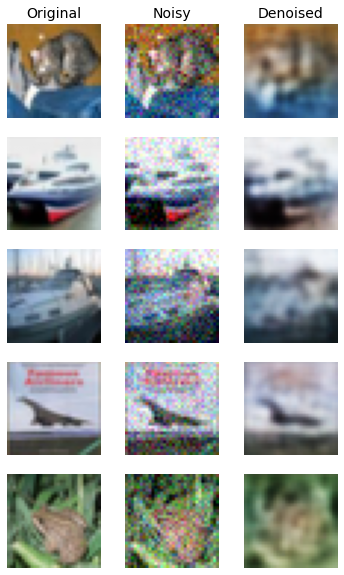

In [79]:
n_images = 5
new_images = X_test[:n_images]
new_images_noisy = new_images + np.random.randn(n_images, 32, 32, 3) * 0.1
new_images_denoised = denoising_ae.predict(new_images_noisy)

plt.figure(figsize=(6, n_images * 2))
for index in range(n_images):
    plt.subplot(n_images, 3, index * 3 + 1)
    plt.imshow(new_images[index])
    plt.axis('off')
    if index == 0:
        plt.title("Original")
    plt.subplot(n_images, 3, index * 3 + 2)
    plt.imshow(new_images_noisy[index].clip(0., 1.))
    plt.axis('off')
    if index == 0:
        plt.title("Noisy")
    plt.subplot(n_images, 3, index * 3 + 3)
    plt.imshow(new_images_denoised[index])
    plt.axis('off')
    if index == 0:
        plt.title("Denoised")

plt.show()

## 11.
_Exercise: Train a variational autoencoder on the image dataset of your choice, and use it to generate images. Alternatively, you can try to find an unlabeled dataset that you are interested in and see if you can generate new samples._


See the VAE code above.

## 12.
_Exercise: Train a DCGAN to tackle the image dataset of your choice, and use it to generate images. Add experience replay and see if this helps. Turn it into a conditional GAN where you can control the generated class._


TODO